In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from matplotlib import pyplot as plt
import aplpy
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import fil_finder
from fil_finder import FilFinder2D, Filament2D
from astropy.io import fits
import tqdm
import copy
import random
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import os


import warnings # warningが気になる方はこちらも
warnings.simplefilter('ignore')

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 533  750
Pixel scale (CDELT): [1. 1.]
Axis units (CUNIT): ['', '']


INFO: Auto-setting vmin to -3.475e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.729e+00 [aplpy.core]


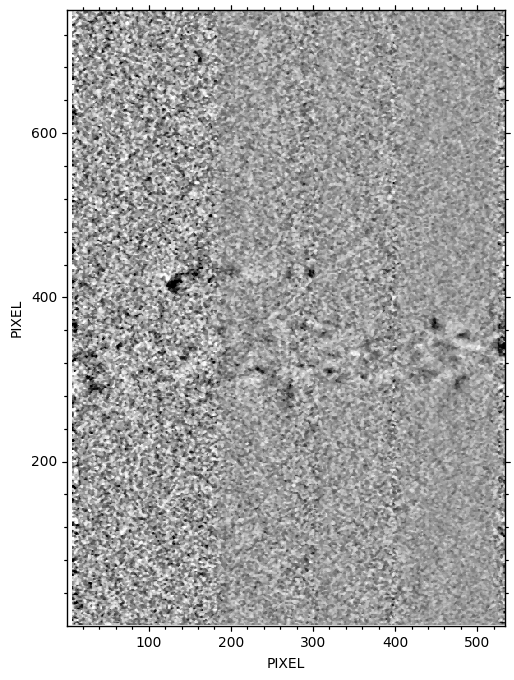

In [9]:
hdu = fits.open("/Users/naoj306/Desktop/find/aquila_12/slice/no_wcs_diff_1-99_nonan_fil_3-3/12CO_x500_slice_diff_nonan.fits")[0]  # 普通は [0] です。
w = WCS(hdu)
print(w)
print("Pixel scale (CDELT):", w.wcs.cdelt)
print("Axis units (CUNIT):", w.wcs.cunit)
fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(hdu, slices=[0], convention='wells', figure=fig)
f.show_colorscale(cmap="Greys", aspect="equal")


WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 533  750
Pixel scale (CDELT): [1. 1.]
Axis units (CUNIT): ['', '']
INFO: Auto-setting vmin to -2.229e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.494e+00 [aplpy.core]


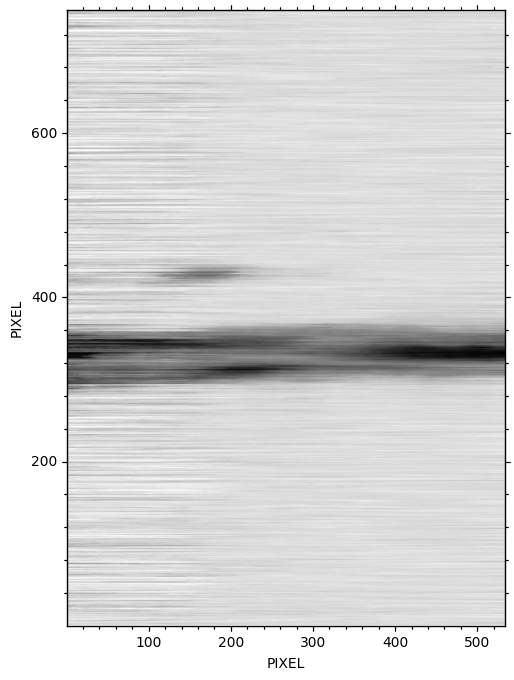

In [10]:
hdu = fits.open("/Users/naoj306/Desktop/find/aquila_12/slice/no_wcs_filt_1-99_nonan/12CO_x500_slice_filtered_nonan.fits")[0]  # 普通は [0] です。
w = WCS(hdu)
print(w)
print("Pixel scale (CDELT):", w.wcs.cdelt)
print("Axis units (CUNIT):", w.wcs.cunit)
fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(hdu, slices=[0], convention='wells', figure=fig)
f.show_colorscale(cmap="Greys", aspect="equal")


add wcs

In [8]:
# 定义原始和目标文件夹路径
source_folder = '/Users/naoj306/Desktop/find/slice/no_wcs_diff_1-99_nonan_fil_3-3/'
target_folder = '/Users/naoj306/Desktop/find/slice/new_wcs_diff_1-99_nonan_fil_3-3/'

# 确保目标文件夹存在
os.makedirs(target_folder, exist_ok=True)

# 遍历原始文件夹中的所有文件
for filename in os.listdir(source_folder):
    if filename.endswith('.fits'):
        # 构建完整的文件路径
        file_path = os.path.join(source_folder, filename)

        # 打开FITS文件
        hdu = fits.open(file_path)[0]

        # 创建一个 WCS 对象并设置基本参数
        w = WCS(naxis=2)
        w.wcs.crpix = [hdu.header['NAXIS1'] / 2, hdu.header['NAXIS2'] / 2]  # 像素坐标系中心
        w.wcs.cdelt = np.array([-0.000277778, 0.000277778])  # 像素尺度，单位是度
        w.wcs.crval = [0, 0]  # 参考点的坐标（经度和纬度），需根据你的数据来设置
        w.wcs.ctype = ["RA---TAN", "DEC--TAN"]  # 坐标类型

        # 更新 FITS 头部信息
        hdu.header.update(w.to_header())

        # 构建带有 '_updated' 后缀的新文件名
        new_filename = filename.replace('.fits', '_updated.fits')
        new_file_path = os.path.join(target_folder, new_filename)

        # 保存更新后的FITS文件
        hdu.writeto(new_file_path, overwrite=True)

        print(f"Updated FITS file saved: {new_file_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/naoj306/Desktop/find/slice/no_wcs_diff_1-99_nonan_fil_3-3/'

mask and skel

In [ ]:
# import os
# import matplotlib.pyplot as plt
# from astropy.io import fits
# from skimage.morphology import medial_axis
# from fil_finder import FilFinder2D
# from astropy import units as u
# 
# # 定义文件夹路径
# folder_path = '/Users/naoj306/Desktop/find/slice_new_wcs'
# target_folder = '/Users/naoj306/Desktop/find/images/mask_and_skel'
# distance = 150 * u.pc
# BMAJ = 30.0 * u.arcsec
# 
# # 遍历文件夹中的所有FITS文件
# for filename in os.listdir(folder_path):
#     if filename.endswith('.fits'):
#         # 构建完整的文件路径
#         file_path = os.path.join(folder_path, filename)
#         
#         # 读取FITS文件
#         with fits.open(file_path) as hdul:
#             hdu = hdul[0]
#             data = hdu.data
#             
#             # 创建 FilFinder2D 实例
#             fil = FilFinder2D(image=data)
#             fil.preprocess_image(skip_flatten=True)
#             
#             # 创建掩模
#             mask_created = fil.create_mask(
#                 verbose=True,
#                 adapt_thresh=3 * u.pix,
#                 smooth_size=1 * u.pix,
#                 size_thresh=3 * u.pix**2,
#                 glob_thresh=1.5,
#                 fill_hole_size=1 * u.pix**2
#             )
#             
#             # 生成骨架
#             fil.skeleton, distance = medial_axis(fil.mask, return_distance=True)
#             
#             # 可视化：创建一个横向的图像来展示原图、掩模和骨架
#             fig, axes = plt.subplots(1, 3, figsize=(13, 5))
#             axes[0].imshow(data, cmap='gray', origin='lower')
#             axes[0].set_title('Original Image')
#             axes[1].imshow(fil.mask, cmap='gray', origin='lower')
#             axes[1].set_title('Mask')
#             axes[2].imshow(fil.skeleton, cmap='gray', origin='lower')
#             axes[2].set_title('Medial Axis Skeleton')
#             plt.colorbar(axes[2].imshow(fil.skeleton, cmap='gray', origin='lower'), ax=axes[2])
#             
#             # 保存图像到目标文件夹
#             save_path = os.path.join(target_folder, f'{filename}_analysis.png')
#             plt.suptitle(f'Analysis for {filename}')
#             plt.tight_layout()
#             plt.savefig(save_path)
#             plt.close()  
#             print(f"Image saved: {save_path}")


histogram

In [ ]:
# import glob
# from astropy.io import fits
# from astropy import units as u
# import matplotlib.pyplot as plt
# import numpy as np
# from skimage.morphology import medial_axis
# from astropy.wcs import WCS
# from fil_finder import FilFinder2D, Filament2D
# import tqdm
# 
# # 设置文件路径
# path = "/Users/naoj306/Desktop/find/slice_no_wcs/*.fits"
# save_path = "/Users/naoj306/Desktop/find/images/histogram"  # 设置保存图片的路径
# 
# min_length = 10 * u.pix # この長さを超えていなければフィラメントとして認めない
# max_dist = 30 * u.pix # フィラメントの幅を見積もるために強度をサーチしに行く最大距離
# 
# # 用glob匹配所有FITS文件
# for file in glob.glob(path):
#     filename = os.path.basename(file)
#     print(f"Processing {file}...")
#     
#     # 读取FITS文件
#     hdu = fits.open(file)[0]
#     w = WCS(hdu.header)
#     
#     # 初始化 FilFinder2D 对象
#     fil = FilFinder2D(image=hdu.data)
#     fil.preprocess_image(skip_flatten=True)
#     
#     # 创建掩模并生成骨架
#     mask_created = fil.create_mask(
#         verbose=True,
#         adapt_thresh=3 * u.pix,
#         smooth_size=1 * u.pix,
#         size_thresh=3 * u.pix**2,
#         glob_thresh=1.5,
#         fill_hole_size=1 * u.pix**2
#     )
#     fil.skeleton, distance = medial_axis(fil.mask, return_distance=True)
#     
#     # 分析骨架
#     try:
#         fil.analyze_skeletons(branch_thresh=5*u.pix, prune_criteria='length', skel_thresh=1*u.pix)
#     except Exception as e:
#         print(f"Error analyzing skeleton for {file}: {e}")
#     
#     # 初始化结果数组
#     ori_branches_array = []
#     total_intensity_branches_array = []
#     length_branches_array = []
#     width_branches_array = []
#     width_err_branches_array = []
#     pos_x_branches_array, pos_y_branches_array = [], []
#     
#     # 处理每个分支
#     for fil_tempo in tqdm.tqdm(fil.filaments):
#         y_start, x_start = fil_tempo.pixel_extents[0][0], fil_tempo.pixel_extents[0][1]
#         fil_tempo.rht_branch_analysis()
#         ori_branches_tempo = np.rad2deg(fil_tempo.orientation_branches.value)
#         for i in range(len(fil_tempo.branch_pts())):
#             pixels_tempo = fil_tempo.branch_properties["pixels"][i]
#             y_pix_all = pixels_tempo[:,0]
#             x_pix_all = pixels_tempo[:,1]
#             pos_x_tempo = int(np.nanmax(x_pix_all)/2-np.nanmin(x_pix_all)/2)+np.nanmin(x_pix_all)+x_start
#             pos_y_tempo = int(np.nanmax(y_pix_all)/2-np.nanmin(y_pix_all)/2)+np.nanmin(y_pix_all)+y_start
#             ori_branch_tempo = ori_branches_tempo[i]
#             pos_x_wcs_tempo, pos_y_wcs_tempo = w.wcs_pix2world(pos_x_tempo, pos_y_tempo, 0)
#             pos_x_branches_array.append(pos_x_tempo)
#             pos_y_branches_array.append(pos_y_tempo)
#             if fil_tempo.branch_properties["length"][i]>min_length:
#                 ori_branches_array.append(ori_branch_tempo)
#                 branch_tempo_coords = (y_pix_all+y_start, x_pix_all+x_start)
#                 branch_tempo = Filament2D(branch_tempo_coords)
#                 branch_tempo.skeleton_analysis(hdu.data)
#                 branch_tempo.width_analysis(hdu.data, deconvolve_width=False, max_dist=max_dist)
#                 width_tempo, width_err_tempo = branch_tempo.radprof_fwhm()
#                 total_intensity_branches_array.append(branch_tempo.total_intensity())
#                 length_branches_array.append(fil_tempo.branch_properties["length"][i].value)
#                 width_branches_array.append(width_tempo.value)
#                 width_err_branches_array.append(width_err_tempo.value)
#             else:
#                 ori_branches_array.append(np.nan)
#                 total_intensity_branches_array.append(np.nan)
#                 length_branches_array.append(np.nan)
#                 width_branches_array.append(np.nan)
#                 width_err_branches_array.append(np.nan)
#     ori_branches_array = np.array(ori_branches_array)
#     total_intensity_branches_array = np.array(total_intensity_branches_array)
#     length_branches_array = np.array(length_branches_array)
#     width_branches_array = np.array(width_branches_array)
#     width_err_branches_array = np.array(width_err_branches_array)
#     pos_x_branches_array = np.array(pos_x_branches_array)
#     pos_y_branches_array = np.array(pos_y_branches_array)
#     
#     fig = plt.figure(figsize=(4, 4))
#     plt.hist(ori_branches_array, bins=20, color='blue', alpha=0.7)  # 可以调整bins和颜色等
#     plt.xlabel("Orientation to the North (CCW) (degree)")
#     plt.ylabel("Number of filaments")
#     plt.title(f'Histogram of {filename}')
#     save_filename = os.path.join(save_path, f'{filename}_histogram.png')
#     plt.savefig(save_filename)
#     plt.close(fig)  # 关闭图像以释放内存
#     print(f"Histogram saved to {save_filename}")
# 
# # 这将为路径中的每个FITS文件执行您的代码，并将处理结果逐个文件地展示出来。


filament 

In [ ]:
import glob
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import medial_axis
from astropy.wcs import WCS
from fil_finder import FilFinder2D, Filament2D
import tqdm
import re

# 设置文件路径
path = "/Users/naoj306/Desktop/find/slice/new_wcs_diff_1-99_nonan_fil_3-3/*.fits"
save_path_fil = "/Users/naoj306/Desktop/find/images/fila_nonan_diff_1-99_3-3"
save_path_txt = "/Users/naoj306/Desktop/find/location/nonan_diff_1-99_3-3"

min_length = 10 * u.pix # この長さを超えていなければフィラメントとして認めない
max_dist = 50 * u.pix # フィラメントの幅を見積もるために強度をサーチしに行く最大距離
angle_range = 20
vmin1, vmax1 = 1, 100
vmin2, vmax2 = -90, 90
plt.rcParams["font.family"] = "Serif"


# 用glob匹配所有FITS文件
for file in glob.glob(path):
    filename = os.path.basename(file)
    # 检查每个文件是否已经被处理
    base_number = filename.split('_')[1]  # 从文件名获取数字
    
    output_txt = f"12CO_{base_number}_fila.txt"  # 文件名
    
    output_path = os.path.join(save_path_txt, output_txt)
    # 如果输出文件已存在，跳过处理
    if os.path.exists(output_path):
        print(f"File {output_txt} already exists, skipping {filename}...")
        continue
    print(f"Processing {file}...")

    hdu = fits.open(file)[0]
    w = WCS(hdu.header)
    
    # 初始化 FilFinder2D 对象
    fil = FilFinder2D(image=hdu.data)
    fil.preprocess_image(skip_flatten=True)
    
    # 创建掩模并生成骨架
    mask_created = fil.create_mask(
        verbose=True,
        adapt_thresh=3 * u.pix,
        smooth_size=1 * u.pix,
        size_thresh=3 * u.pix**2,
        glob_thresh=0.5,
        fill_hole_size=1 * u.pix**2
    )
    fil.skeleton, distance = medial_axis(fil.mask, return_distance=True)
    
    # 分析骨架
    try:
        fil.analyze_skeletons(branch_thresh=7*u.pix, prune_criteria='length', skel_thresh=1*u.pix)
    except Exception as e:
        print(f"Error analyzing skeleton for {file}: {e}")
    
    # 初始化结果数组
    selected_filaments = []
    pos_x_wcs_list = []
    pos_y_wcs_list = []
    color_tempo_list = []
    cmap = plt.get_cmap("jet")
    
    # 处理每个分支
    for fil_tempo in tqdm.tqdm(fil.filaments):
        y_start, x_start = fil_tempo.pixel_extents[0][0], fil_tempo.pixel_extents[0][1]
        fil_tempo.rht_branch_analysis()
        ori_branches_tempo = np.rad2deg(fil_tempo.orientation_branches.value)
        for i in range(len(fil_tempo.branch_pts())):
            if fil_tempo.branch_properties["length"][i]>min_length:
                pixels_tempo = fil_tempo.branch_properties["pixels"][i]
                y_pix_all = pixels_tempo[:,0]
                x_pix_all = pixels_tempo[:,1]
                pos_x_tempo = int(np.nanmax(x_pix_all)/2-np.nanmin(x_pix_all)/2)+np.nanmin(x_pix_all)+x_start
                pos_y_tempo = int(np.nanmax(y_pix_all)/2-np.nanmin(y_pix_all)/2)+np.nanmin(y_pix_all)+y_start
                ori_branch_tempo = ori_branches_tempo[i]
                pos_x_wcs_tempo, pos_y_wcs_tempo = w.wcs_pix2world(pos_x_tempo, pos_y_tempo, 0)
                branch_tempo_coords = (y_pix_all+y_start, x_pix_all+x_start)
                branch_tempo = Filament2D(branch_tempo_coords)
                branch_tempo.skeleton_analysis(hdu.data)
                
                try:
                    branch_tempo.width_analysis(hdu.data, deconvolve_width=False, max_dist=max_dist)
                except ValueError as e:
                    print(f"Width analysis failed for {file} on branch {i}: {e}")
                    continue 
                
                branch_tempo.width_analysis(hdu.data, deconvolve_width=False)
                pos_x_wcs_array, pos_y_wcs_array = w.wcs_pix2world(x_pix_all+x_start, y_pix_all+y_start, 0)
                pos_x_wcs_list += list(pos_x_wcs_array)
                pos_y_wcs_list += list(pos_y_wcs_array)
                color_tempo = rgb2hex(cmap(Normalize(vmin=vmin2, vmax=vmax2)(ori_branch_tempo)))
                color_tempo_list += [color_tempo]*len(pos_x_wcs_array)
                
                if -angle_range <= ori_branch_tempo <= angle_range:
                    pixels_tempo = fil_tempo.branch_properties["pixels"][i]
                    y_pix_all = pixels_tempo[:,0]
                    x_pix_all = pixels_tempo[:,1]
                    x_min, x_max = x_start + np.min(x_pix_all), x_start + np.max(x_pix_all)
                    y_min, y_max = y_start + np.min(y_pix_all), y_start + np.max(y_pix_all)
                    # 存储选中的云丝分支信息
                    selected_filaments.append(f"{x_min} {x_max} {y_min} {y_max}")
                    
    # location output
    match = re.search(r'x(\d+)_slice_diff_nonan_updated\.fits$', filename)
    if match:
        xch = match.group(1)  # 提取出的数字，为字符串形式
        txt_output_path = os.path.join(save_path_txt, f"12CO_x{xch}_fila.txt")
        # 写入文件
        with open(txt_output_path, 'w') as f:
            f.write(f"{xch} {len(selected_filaments)}\n")  # 将number和选中的filament数量写在文件的第一行
            for filament in selected_filaments:
                f.write(filament + "\n")
        print(f"Saved filament information to {txt_output_path}")
    else:
        print("Filename format does not match expected pattern.")
    
    fig = plt.figure(figsize=(5.33, 7.5))
    f = aplpy.FITSFigure(hdu, slices=[0], figure=fig, subplot=[0.1, 0.1, 0.8, 0.8])
    # f.show_colorscale(vmin = vmin1, vmax = vmax1, stretch="log", cmap="Greys")
    f.show_colorscale(cmap="Greys")
    f.add_colorbar()
    f.colorbar.show()
    f.colorbar.set_width(0.2)
    f.colorbar.set_font(size=15)
    f.colorbar.set_axis_label_text("MJy/str")
    f.colorbar.set_axis_label_font(size=13)
    
       
    f.show_markers(pos_x_wcs_list, pos_y_wcs_list, marker="s", s=5, facecolor=color_tempo_list, edgecolor="none", zorder=11)
    
    print(f"Number of selected filaments within -{angle_range} to {angle_range} degrees: {len(selected_filaments)}")
    for filament_info in selected_filaments:
        print(filament_info)

    ax = fig.add_axes([0.1, 0.92, 0.8, 0.02])  # 你可以调整这些参数以适应你的图形布局
    norm = Normalize(vmin=vmin2, vmax=vmax2)
    cb = ColorbarBase(ax, cmap="jet", orientation="horizontal", norm=norm)
    cb.set_label(f"{filename[:-13]}, Orientation to the North (CCW) (degree)", labelpad=-70, size=15)

    fig.patch.set_facecolor('w')
    
    output_filename = f"{filename[:-13]}_fila.png"  # 文件名
    
    output_file_path = os.path.join(save_path_fil, output_filename)
    f.save(output_file_path, dpi=300)  # 使用高dpi保存图像以保证质量
    plt.show(fig)
    plt.close(fig)  # 关闭图形以释放内存
    print(f"Saved to {output_file_path}")

